# Fast exponential and softmax functions

Based on the bit manupulation of the IEEE 754 floating point numbers.
See N. N. Schraudolph, “A Fast, Compact Approximation of the Exponential Function,” Neural Computation, vol. 11, no. 4, pp. 853–862, May 1999, doi: 10.1162/089976699300016467.

A 32-bit floating point number is given by:
$$ x = (-1)^s (1+m)2^{e-127} $$
where $s$ - sign bit; $m$ - 23-bit mantissa; $e$ - 8-bit exponent;

For bit layout see [this diagram](https://upload.wikimedia.org/wikipedia/commons/d/d2/Float_example.svg).

Writing some integer value $i$ in bit field of the exponent and read back as a float number will give value of$2^{i-127}$. 

So dividing $x$ by dividing by $\ln(2)$, shifting the value $x/\ln(2)+127$ by 23 bit, and reading back the bits of resulting integer number as a flot will give value of the $e^x$. Correction factor $C$ allows adjusting the approximation for some parameters.

$$f(x) = 2^{23} \left(\frac{x}{\ln(2)} + 127 - C\right)$$
In some example following approximation is used with specific values in code $C = 0.057985$:
```C
uint32_t value = (1<<23)*(1.4426950409*x+126.94201519f);
```
Which is then bitcast to floating point number via union type punning.


## Softmax

Softmax is a function over a vector $\mathbf{X}$:

$$ \sigma(\mathbf{X})_i = \frac{e^{x_i}}{\sum\limits_{j=0}^{N}e^{x_j}} $$


When calculating softmax the maximum is substracted from initial data for numerical stability - to avoid overflows.


C = 0.057985
0.6931471805599453
Upper bound: 2.000000
Lower bound: 4435613.826217
Lowest maximum relative error: gamma = 0.030275
Lowest maximum relative error: c = 366392.997292 0.043677
Lowest RMS error: c = 486411.880684 0.057985
Lowest mean error: c = 545947.460827 0.065082


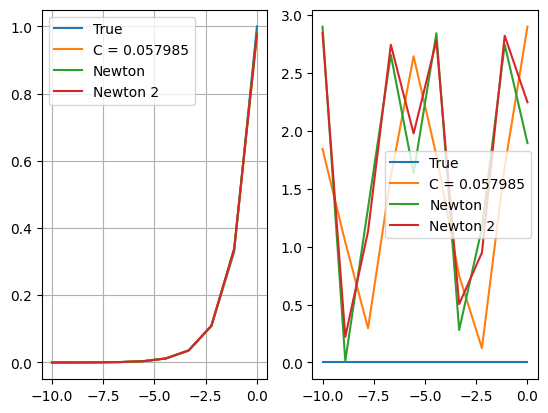

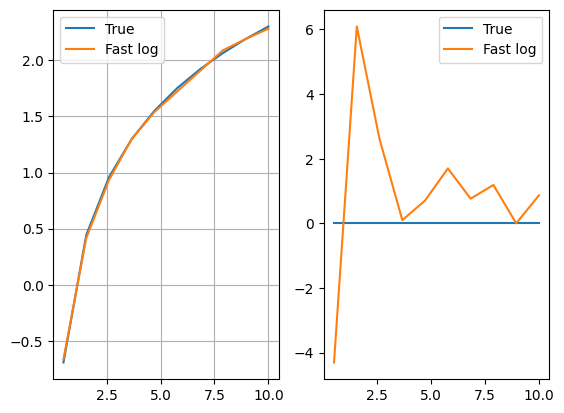

In [31]:
import numpy as np
from matplotlib import pyplot as plt
import struct

SIZE = 10

C = 127 - 126.94201519

print("C = {:f}".format(127 - 126.94201519))
print(1 / np.log2(np.e))


def fast_exp(x, c=C):
    A = np.float32(1.4426950409) * np.ones((SIZE), np.float32)
    K = np.float32(1 << 23) * np.ones((SIZE), np.float32)
    y = np.multiply(K, (A * x + 127 - c), dtype="f")
    z = np.int32(y)
    v = z.view(np.float32)
    return v


def fast_log(x):
    sigma = 0.0430357
    v = x.view(np.int32)
    return 0.6931471805599453 * np.float32(v / (2**23) - (127 - sigma))


def fast_exp_newtons(x):
    y = fast_exp(x)
    y2 = y - y * fast_log(y) + y * x
    return y2


def fast_exp_newtons2(x):
    y = fast_exp(x)
    y2 = y - y * fast_log(y) + y * x
    y3 = y2 - y2 * fast_log(y2) + y2 * x
    return y3


def bounds():
    print("Upper bound: {:f}".format(fast_exp([0], -1)[0]))
    print(
        "Lower bound: {:f}".format(2**23 * ((1 - (np.log(np.log(2)) + 1)) / np.log(2)))
    )
    gamma = np.log(np.log(2) + 2 / np.e) - np.log(2) - np.log(np.log(2))
    c = gamma * 2**23 / np.log(2)
    print("Lowest maximum relative error: gamma = {:f}".format(gamma))
    print("Lowest maximum relative error: c = {:f} {:f}".format(c, c / 2**23))
    c = np.log(3 / (8 * np.log(2)) + 0.5) / np.log(2)
    print("Lowest RMS error: c = {:f} {:f}".format(2**23 * c, c))
    gamma = 0.045111411
    c = gamma / np.log(2)
    print("Lowest mean error: c = {:f} {:f}".format(2**23 * c, c))


def softmax(x, func):
    exps = func(x)
    sums = np.sum(exps)
    return func(x) / sums


def get_err(x, tr, app):
    return 100 * np.abs(tr(x) - app(x)) / tr(x)


def plot(x, funcs, labels):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.grid(True)
    for func in funcs:
        ax1.plot(x, func(x))
        ax2.plot(x, get_err(x, funcs[0], func))
    ax1.legend(labels)
    ax2.legend(labels)


bounds()

x = np.linspace(-10, 0.0, SIZE, dtype=np.float32)
x2 = np.linspace(0.5, 10.0, SIZE, dtype=np.float32)

plot(
    x,
    [np.exp, fast_exp, fast_exp_newtons, fast_exp_newtons2],
    ["True", "C = 0.057985", "Newton", "Newton 2"],
)
plot(x2, [np.log, fast_log], ["True", "Fast log"])